In [94]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as pl
from sys import stdout
from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from tick.simulation import SimuCoxRegWithCutPoints
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from tick.inference import CoxRegression
from tick.optim.prox import ProxTV
import sys
sys.path.append('../')
from binacox import compute_score, auto_cutoff, p_value_cut, \
                    bootstrap_cut_max_t, get_groups
from lifelines.utils import concordance_index
from prettytable import PrettyTable
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

### Load data

In [95]:
cancers = ["BRCA", "GBM", "KIRC"]
data = {}
for cancer in cancers:
    inputdir = "./data/%s/rna/" % cancer
    X = pd.read_csv(inputdir + 'X.csv')
    X = X.fillna(X.mean())
    Y = np.ravel(pd.read_csv(inputdir + 'T.csv')) + 1
    delta = np.ravel(pd.read_csv(inputdir + 'delta.csv'))
    data[cancer] = {"X": X, "Y": Y, "delta": delta}
    print("%s loaded: n=%s, p=%s" % (cancer, X.shape[0], X.shape[1]))

BRCA loaded: n=1211, p=20531
GBM loaded: n=168, p=20531
KIRC loaded: n=605, p=20531


In [105]:
inputdir = "./data/%s/rna/" % cancer
X_orig = pd.read_csv(inputdir + 'X.csv')

148.2362289256198

In [107]:
X_orig[features_selected[0]].head()

0     53.9472
1      4.8570
2     72.4638
3     74.3119
4    187.6362
Name: KIF20A|10112, dtype: float64

In [110]:
(X[features_selected[0]] * scaler.scale_[0] + scaler.mean_[0]).head()

0     53.9472
1      4.8570
2     72.4638
3     74.3119
4    187.6362
Name: KIF20A|10112, dtype: float64

In [102]:
cancer = "KIRC"
X = data[cancer]["X"]
features_selected = data[cancer]["features_selected"]
scaler = data[cancer]["scaler"]
scaler.mean_
scaler.scale_

array([  217.4733186 ,   568.07481306,  2093.60895776,    79.49352134,
         186.40318054,   777.60776694,   562.21305433,   226.75905851,
          25.1918046 ,    17.07940494,    94.16411788,    81.5908248 ,
          67.37862243,   479.66330783,    94.05043785,   356.26904534,
          80.861603  ,    54.14757885,  9438.97548266,   320.07518377,
        1746.93502305,   120.6846288 ,   800.95715744,  3236.16967132,
          92.04598305,   150.82838336,   174.74243029,    30.75577998,
        2183.82854741,    94.97715802,   169.88269913,    76.99065071,
         164.38309837,   123.22080902,   157.99385493,  1159.20893744,
         216.98356677,    86.42754137,   651.87884418,   142.77734736,
         122.80032066,    41.59315248,   223.26194527,   131.55091467,
         161.18975033,   494.8679018 ,  3219.62536216,    59.22507234,
         102.02578894,   584.92238041])

In [100]:
scaler.mean_

array([  1.48236229e+02,   1.45978874e+02,   6.08002515e+03,
         4.46879233e+01,   1.22644159e+02,   2.19844686e+03,
         2.97601855e+02,   6.26536144e+01,   7.49560215e+00,
         3.38758909e+00,   6.30452045e+01,   9.97749296e+01,
         5.45439643e+01,   7.36444759e+02,   5.51477840e+01,
         5.59645719e+02,   8.32991096e+01,   3.76813051e+01,
         9.67723498e+03,   8.60841187e+02,   1.12235827e+03,
         7.55503521e+01,   2.31885436e+02,   5.71611107e+03,
         6.85644511e+01,   1.72066430e+02,   5.14311399e+02,
         2.17223873e+01,   3.71004197e+03,   5.66551511e+01,
         4.99357903e+02,   1.19934816e+02,   5.40939364e+02,
         3.04285249e+02,   2.01953752e+02,   1.05734696e+03,
         2.27220973e+02,   4.47022879e+01,   8.90774007e+02,
         1.50947629e+02,   3.74153382e+01,   4.51482992e+01,
         5.01361462e+02,   1.02458506e+02,   4.16768892e+02,
         1.30536659e+03,   3.28052823e+03,   3.61804402e+01,
         8.18790552e+01,

### Screening

In [96]:
def get_abs_max_jump(coeffs):
    if len(coeffs) > 1:
        abs_max_jump = np.abs(coeffs[1:] - coeffs[:-1]).max()
    else:
        abs_max_jump = 0
    return abs_max_jump

In [97]:
run_screening = False
screening_markers = {}
if run_screening:
    for cancer in cancers:
        X = data[cancer]["X"]
        Y = data[cancer]["Y"]
        delta = data[cancer]["delta"]
        n_features = X.shape[1]
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        n_cuts = 50
        binarizer = FeaturesBinarizer(n_cuts=n_cuts)
        screening_marker = pd.Series(index=X.columns)
        prox_tv = ProxTV(1)
        for j in range(n_features):
            stdout.write("\r%s screening: %d/%s" % (cancer, j + 1, n_features))
            stdout.flush()
            X_j = np.atleast_2d(X.ix[:, j]).T
            X_bin_j = binarizer.fit_transform(np.array(X_j))
            blocks_start = binarizer.blocks_start
            blocks_length = binarizer.blocks_length
            solver = 'agd'
            learner = CoxRegression(penalty='binarsity', tol=1e-5,
                                    solver=solver, verbose=False, 
                                    max_iter=100, step=0.3,
                                    blocks_start=blocks_start,
                                    blocks_length=blocks_length,
                                    warm_start=True, C=25)
            learner._solver_obj.linesearch = False
            learner.fit(X_bin_j, Y, delta)
            coeffs = learner.coeffs
            screening_marker[X.columns[j]] = prox_tv.value(learner.coeffs)
            #screening_marker[X.columns[j]] = get_abs_max_jump(learner.coeffs) 
        screening_marker.to_csv('./screening/screening_marker_%s' % cancer)
        screening_markers[cancer] = screening_marker

Screen the top 50 features using TV norm on univariate BinaCox model.


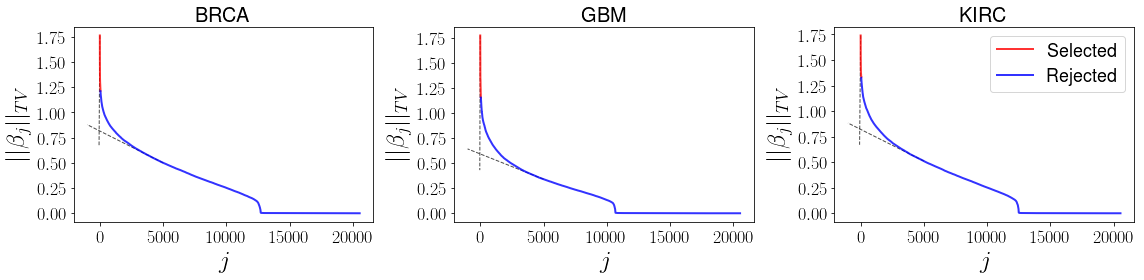

In [98]:
# number of selected features
p = 50
print("Screen the top %s features using TV norm on univariate BinaCox model." % p)
Y_3_s = {"BRCA":.67, "GBM":.43, "KIRC":.67}
fig = pl.figure(figsize=(16, 4))
for i, cancer in enumerate(cancers):
    ax = fig.add_subplot(1, 3, i + 1)
    screening_marker = pd.Series.from_csv('./screening/screening_marker_%s' % cancer)
    n_features = screening_marker.size
    screening_marker = screening_marker.sort_values(ascending=False)
    lw = 2
    alpha = .8
    label = ""
    if i == 2:
        label = 'Selected'
    ax.plot(range(p), screening_marker[:p], 'r', 
            lw=lw, alpha=alpha, label=label)
    if i == 2:
        label = 'Rejected'
    ax.plot(range(p, n_features), screening_marker[p:], 
            'b', lw=lw, alpha=alpha, label=label)
    pl.xlabel(r'$j$', fontsize=25)
    pl.ylabel(r'$||\beta_j||_{TV}$', fontsize=25)
    pl.tick_params(axis='x', which='both', top='off')
    pl.xticks(fontsize = 18)
    pl.yticks(fontsize = 18)
    pl.legend(fontsize=18) 
    pl.title(cancer, fontsize=20)

    x_1_s, y_1_s = 0, screening_marker[0]
    x_2_s, y_2_s = p - 1, screening_marker[p - 1]
    y_3_s = Y_3_s[cancer]
    x_1_r, y_1_r = 5000, screening_marker[5000]
    x_2_r, y_2_r = 4000, screening_marker[4000]
    x_3_r = -1000
    
    alpha = .7
    lw = 1
    a_r = (y_1_r - y_2_r) / (x_1_r - x_2_r)
    pl.plot([x_1_r, x_3_r], 
            [y_1_r, a_r * x_3_r + y_1_r - x_1_r * a_r], 
            'k--', lw=lw, alpha=alpha, zorder=0)
    a_s = (y_1_s - y_2_s) / (x_1_s - x_2_s)
    pl.plot([x_1_s, y_3_s / a_s - y_1_s - x_1_s * a_s], 
            [y_1_s, y_3_s], 'k--', lw=lw, alpha=alpha, zorder=0)
    
    X = data[cancer]["X"]
    features_selected = screening_marker[:p].index
    X = X[features_selected]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=features_selected)
    data[cancer]["X"] = X
    data[cancer]["features_selected"] = features_selected
    data[cancer]["scaler"] = scaler
    
pl.tight_layout()
pl.savefig('./figures/sreening_selection.pdf', bbox_inches='tight')
pl.show()

## Estimation & visualization

Done binarizing BRCA in 5.15e-02 seconds.

Done estimating with auto_cutoff method in 9.54e+01 seconds.

Done Lausen & Schumacher correction in 2.32e-01 seconds.

BRCA estimated cutpoints values for top-10 feature
+---------------+------------------------+-----------------------+--------------------------------+
|      Gene     |   Cut-points BinaCox   | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+---------------+------------------------+-----------------------+--------------------------------+
|   PGK1|5230   |   10205.72, 12036.29   |        12036.29       |            12036.29            |
|  TRPM4|54795  |    906.10, 1667.16     |         906.10        |             906.10             |
|  GEMIN6|79833 |         270.36         |         130.43        |             130.43             |
|   PLCH2|9651  | 200.74, 273.04, 382.87 |         382.87        |             382.87             |
|  GRIN2D|2906  |      12.01, 17.85      |         14.25         |             14.25  

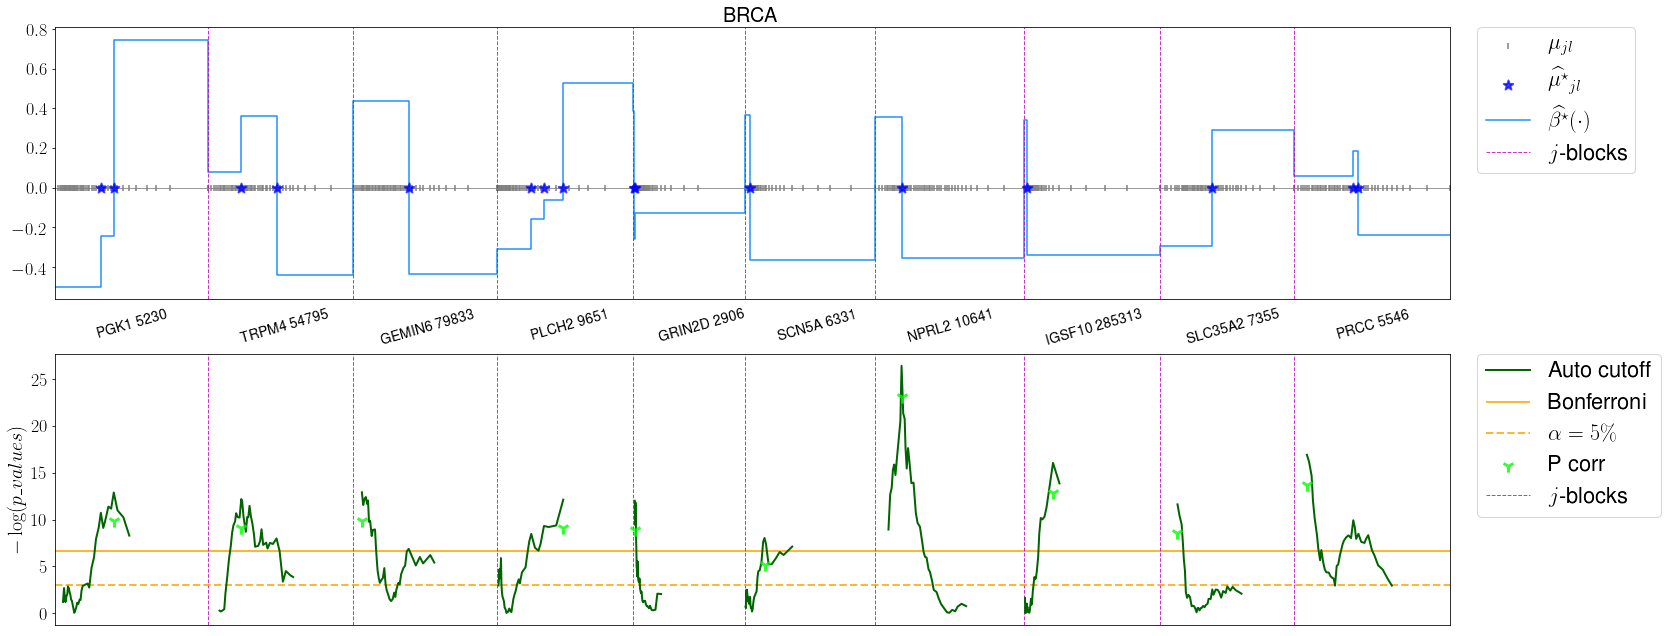

Done binarizing GBM in 2.33e-02 seconds.

Done estimating with auto_cutoff method in 8.00e+01 seconds.

Done Lausen & Schumacher correction in 2.45e-01 seconds.

GBM estimated cutpoints values for top-10 feature
+----------------+--------------------+-----------------------+--------------------------------+
|      Gene      | Cut-points BinaCox | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+----------------+--------------------+-----------------------+--------------------------------+
|  KTI12|112970  |   219.60, 305.70   |         219.60        |             219.60             |
|   SOD3|6649    |   326.40, 606.48   |          None         |             326.40             |
| MGC2752|65996  |   847.59, 996.93   |         996.93        |             996.93             |
| ANGPTL7|10218  |        0.50        |          0.50         |              0.50              |
|  PITPNA|5306   |  2453.29, 3025.76  |        2453.29        |            2453.29             |
|   MRI1|842

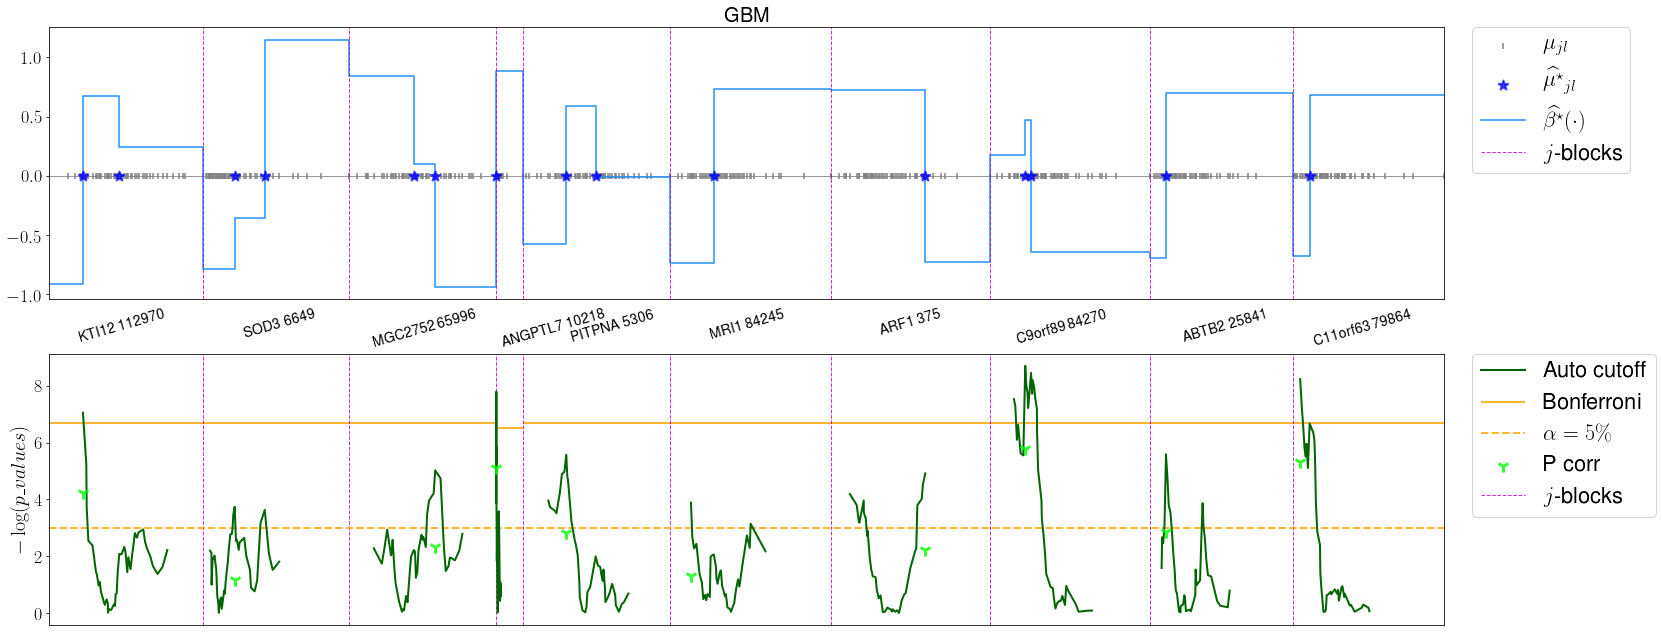

Done binarizing KIRC in 3.50e-02 seconds.

Done estimating with auto_cutoff method in 1.31e+02 seconds.

Done Lausen & Schumacher correction in 2.19e-01 seconds.

KIRC estimated cutpoints values for top-10 feature
+-----------------+--------------------+-----------------------+--------------------------------+
|       Gene      | Cut-points BinaCox | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+-----------------+--------------------+-----------------------+--------------------------------+
|  C12orf32|83695 |       360.78       |         558.02        |             558.02             |
|    MARS|4141    |  1196.21, 1350.00  |        1350.00        |            1350.00             |
| ATP6V1C2|245973 |    53.77, 66.38    |         66.38         |             66.38              |
|    CUBN|8029    | 4492.29, 13503.73  |        4492.29        |            4492.29             |
|    PTPRH|5794   |        3.32        |          3.32         |              3.32              |
| 

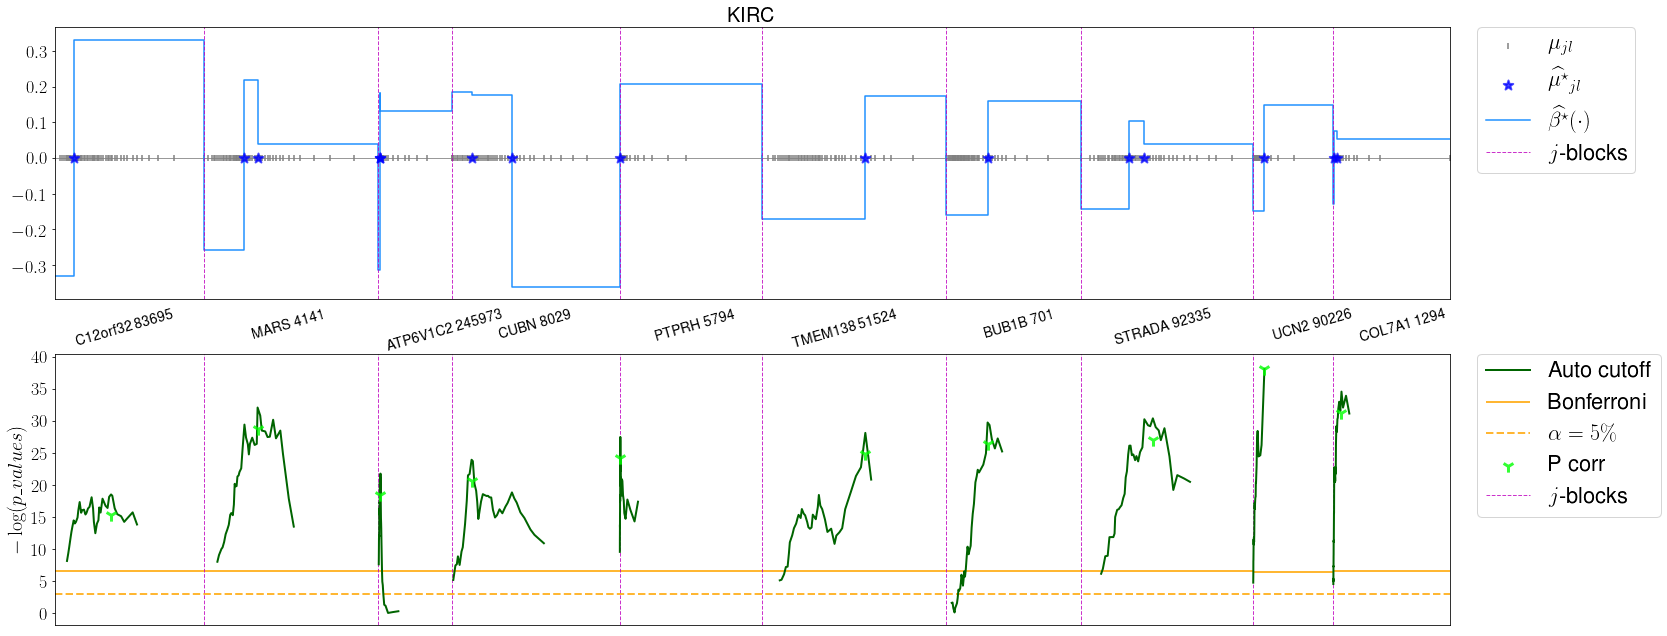

In [122]:
plot_top_k = 10
C_chosen = {"BRCA": 13, "GBM":13.7, "KIRC":11.5}
#cancers = ["KIRC"]
for cancer in cancers:
    print("\n\nRun on %s..." % cancer)
    X = data[cancer]["X"]
    Y = data[cancer]["Y"]
    delta = data[cancer]["delta"]
    features_selected = data[cancer]["features_selected"]
    n_samples, n_features = X.shape
    
    # binarize features
    tic = time()
    n_cuts = 50
    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    X_bin = binarizer.fit_transform(X)
    tac = time()
    print("Done binarizing %s in %.2e seconds." % (cancer, (tac - tic)))
    
    blocks_start = binarizer.blocks_start
    blocks_length = binarizer.blocks_length
    boundaries = binarizer.boundaries
    
    if True:
        # Auto cutoff method
        tic = time()
        epsilon=10
        auto_cutoff_rslt = auto_cutoff(X, boundaries, Y, delta, epsilon=epsilon,
                                       features_names=features_selected)
        tac = time()
        print("\nDone estimating with auto_cutoff method in %.2e seconds." % (tac - tic))

        # Lausen & Schumacher correction
        tic = time()
        p_values_corr = []
        X_ = np.array(X)
        for j in range(n_features):
            p_values_j = auto_cutoff_rslt[j]
            p_values_corr.append(p_value_cut(p_values_j.p_values, p_values_j.values_to_test, 
                                             X_[:, j], epsilon=epsilon))
        tac = time()
        print("\nDone Lausen & Schumacher correction in %.2e seconds." % (tac - tic))
    
    solver = 'agd'
    learner = CoxRegression(penalty='binarsity', tol=1e-5,
                            solver=solver, verbose=False, 
                            max_iter=100, step=0.3,
                            blocks_start=blocks_start,
                            blocks_length=blocks_length,
                            C=C_chosen[cancer], warm_start=True)
    learner._solver_obj.linesearch = False
    learner.fit(X_bin, Y, delta)
    coeffs = learner.coeffs
    all_groups = list()
    cut_points_estimates = {}
    b_star = np.zeros(len(coeffs))
    for j, start in enumerate(blocks_start):
        coeffs_j = coeffs[start:start + blocks_length[j]]
        all_zeros = not np.any(coeffs_j)
        if all_zeros:
            cut_points_estimate_j = np.array([-np.inf, np.inf])
            groups_j = blocks_length[j] * [0]
        else:
            groups_j = get_groups(coeffs_j)        
            jumps_j = np.where(groups_j[1:] - groups_j[:-1] != 0)[0] + 1

            if len(jumps_j) == 0:
                cut_points_estimate_j = np.array([-np.inf, np.inf])
            else:
                cut_points_estimate_j = boundaries[X.columns[j]][jumps_j]
                if cut_points_estimate_j[0] != -np.inf:
                    cut_points_estimate_j = np.insert(cut_points_estimate_j, 0,
                                                    -np.inf)
                if cut_points_estimate_j[-1] != np.inf:
                    cut_points_estimate_j = np.append(cut_points_estimate_j,
                                                    np.inf)
        cut_points_estimates[X.columns[j]] = cut_points_estimate_j   
        if j > 0:
            groups_j += np.max(all_groups) + 1
        all_groups += list(groups_j)
    binarizer = FeaturesBinarizer(method='given',
                                  bins_boundaries=cut_points_estimates)
    X_bin = binarizer.fit_transform(X)
    data[cancer]["X_bin"] = X_bin
    learner = CoxRegression(tol=1e-5, solver=solver, verbose=False, 
                            penalty='none', max_iter=100)
    learner.fit(X_bin, Y, delta)
    final_coeffs = learner.coeffs
    
    # Get final vectors
    right_translations, block_separation = [], []
    b_star_x, b_star_y = [], []
    hat_beta_star = {}
    hat_beta_star_x, hat_beta_star_y = [], []
    K_star, hat_K_star = np.array([]), np.array([])
    previous_max, start, start_ = 0, 0, 0
    mu, mu_star, hat_mu_star = np.array([]), np.array([]), np.array([])

    # Compute final TV norm per feature    
    hat_beta_star_tv = pd.Series()
    prox_tv = ProxTV(1)
    for j in range(n_features):
        hat_mu_star_j = cut_points_estimates[features_selected[j]][1:-1]
        hat_K_star_j = len(hat_mu_star_j)
        hat_beta_star_j = final_coeffs[start_:start_ + hat_K_star_j + 1]
        hat_beta_star[features_selected[j]] = hat_beta_star_j
        #hat_beta_star_tv[features_selected[j]] = [get_abs_max_jump(hat_beta_star_j)]
        hat_beta_star_tv[features_selected[j]] = [prox_tv.value(hat_beta_star_j)]
        start_ += hat_K_star_j + 1

    hat_beta_star_tv.sort_values(ascending=False, inplace=True)
    feature_names_to_plot = hat_beta_star_tv.index[:plot_top_k]
    for j, feature_name_j in enumerate(feature_names_to_plot):
        mu_jk = boundaries[feature_name_j].copy()[1:-1]    
        current_min = np.min(mu_jk)
        right_translation = previous_max
        if(j > 0):
            right_translation += abs(current_min)
        right_translations += [right_translation]
        mu_jk += right_translation
        mu = np.append(mu, mu_jk)
        hat_mu_star_j = cut_points_estimates[feature_name_j][1:-1] + right_translation
        hat_mu_star = np.append(hat_mu_star, hat_mu_star_j)
        hat_K_star_j = len(hat_mu_star_j)
        hat_K_star = np.append(hat_K_star, hat_K_star_j)
        hat_beta_star_j = hat_beta_star[feature_name_j]
        hat_beta_star_x += [current_min if j==0 else previous_max]
        hat_beta_star_y += [hat_beta_star_j[0]]
        for k in range(hat_K_star_j):
            hat_l_jk = np.argmax(np.where(mu_jk <= hat_mu_star_j[k]))
            hat_beta_star_x += [mu_jk[hat_l_jk]]
            hat_beta_star_y += [hat_beta_star_j[k + 1]]
        previous_max = np.max(mu)
        block_separation += [previous_max]
    hat_beta_star_x += [previous_max]
    hat_beta_star_y = [hat_beta_star_y[0]] + hat_beta_star_y
    
    # Visualization
    fig = pl.figure(figsize=(25, 11))
    ax = fig.add_subplot(211)
    ax.axhline(0, c='grey', alpha=.8, lw=1)
    pl.step(hat_beta_star_x, hat_beta_star_y, c='dodgerblue', 
            label=r"$\widehat{\beta^\star}(\cdot)$")
    pl.scatter(hat_mu_star, np.zeros(len(hat_mu_star)), c='b', marker='*',
               s=100, lw=2, label=r"$\widehat{\mu^\star}_{jl}$", zorder=6, alpha=.7)
    pl.scatter(mu, np.zeros(len(mu)), c='grey', marker="|",
              label=r"$\mu_{jl}$")
    pl.tick_params(axis='x', which='both', bottom='off',
                   top='off', labelbottom='off')
    pl.yticks(fontsize = 18)
    y_min, y_max = ax.get_ylim()
    ax.set_xlim([mu[0], mu[-1]])
    previous_separation = mu[0]
    for j in range(plot_top_k):
        label = ''
        if j == 0:
            label = r'$j$-blocks'
        ax.axvline(block_separation[j], c='m', ls='--', 
                   alpha=.8, lw=1, label=label)
        # plot feature names
        feature_names_to_plot_j = feature_names_to_plot[j].replace("|", " ")
        feature_names_to_plot_j = feature_names_to_plot_j.split(" 100270710")[0]
        coeff = .30 - (len(feature_names_to_plot_j) - 8) / 35
        if feature_names_to_plot_j == "PITPNA 5306":
            coeff = .32
        ax.text(previous_separation + coeff * (block_separation[j] - previous_separation), 
                y_min - .07 * (y_max - y_min), feature_names_to_plot_j, rotation=16,
                fontsize=14)
        previous_separation = block_separation[j]
        
    h, l = ax.get_legend_handles_labels()
    h = [h[3], h[2], h[0], h[1]]
    l = [l[3], l[2], l[0], l[1]]
    ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), 
              loc=2, borderaxespad=0, fontsize=22)
    pl.title(cancer, fontsize=20)
    ax = fig.add_subplot(212)
    ax.set_xlim([mu[0], mu[-1]])
    pl.tick_params(axis='x', which='both', bottom='off',
                   top='off', labelbottom='off')
    pl.yticks(fontsize = 18)
    pl.ylabel("$-\log(p\_values)$", fontsize=20)
    
    idx_feature_names_to_plot = [list(features_selected).index(feature_name) 
                                 for feature_name in feature_names_to_plot]
    scaler = data[cancer]["scaler"]
    t = PrettyTable(['Gene', 'Cut-points BinaCox', 'Cut-points Bonferroni',
                     'Cut-points Lausen & Schumacher'])
    for k, j in enumerate(idx_feature_names_to_plot):
        mean_j = scaler.mean_[j]
        scale_j = scaler.scale_[j]
        est_orig_binacox_j = ""
        for cut_pts in cut_points_estimates[feature_names_to_plot[k]][1:-1]:
            cut_points_orig = cut_pts * scale_j + mean_j
            if est_orig_binacox_j != "":
                est_orig_binacox_j += ", "
            est_orig_binacox_j += "%.2f" % cut_points_orig
        p_values_j = auto_cutoff_rslt[j]    
        # Bonferroni detection
        n_tested = len(p_values_j.values_to_test)
        p_values_j_min = p_values_j.p_values.min()
        p_values_j_argmin = p_values_j.p_values.argmin()
        cut_pts_j = p_values_j.values_to_test[p_values_j_argmin]
        cut_pts_orig_j = cut_pts_j * scale_j + mean_j
        est_orig_ac_bonf_j = "None"
        if p_values_j_min < alpha / n_tested:
            est_orig_ac_bonf_j = "%.2f" % cut_pts_orig_j
        # Lausen & Schumacher detection
        est_orig_ac_LS_j = "None"
        if p_values_corr[j] < alpha:
            est_orig_ac_LS_j = "%.2f" % cut_pts_orig_j
        t.add_row([feature_names_to_plot[k], est_orig_binacox_j,
                   est_orig_ac_bonf_j, est_orig_ac_LS_j])
        
        label = ''
        if k == 0:
            label = "Auto cutoff"
        ax.plot(p_values_j.values_to_test + right_translations[k], 
                -np.log(p_values_j.p_values), c='darkgreen', label=label, lw=2, zorder=3)  
        if k == 0:
            label = "P corr"
        arg_min = p_values_j.values_to_test[p_values_j.p_values.argmin()]
        pl.scatter(arg_min + right_translations[k], -np.log(p_values_corr[j]) , c='lime', 
                   marker='1', s=150, lw=3, label=label, zorder=4, alpha=.8)
        if k == 0:
            label = r'$j$-blocks'
        ax.axvline(block_separation[k], c='m', ls='--', 
                   alpha=.8, lw=1, label=label)
    _, y_max = ax.get_ylim()
    for k, j in enumerate(idx_feature_names_to_plot):
        p_values_j = auto_cutoff_rslt[j]
        label = ""        
        if k == 0:
            label = "Bonferroni"
            min_val = mu[0]
        else:
            min_val = block_separation[k - 1]
        n_tested = p_values_j.values_to_test.shape[0]
        pl.hlines(-np.log(.05/n_tested), min_val, block_separation[k], colors='orange', 
                   linestyles='-', alpha=.8, lw=2, label=label)
    ax.axhline(-np.log(.05), c='orange', ls='--', 
               alpha=.8, lw=2, label=r'$\alpha=5\%$')
    h, l = ax.get_legend_handles_labels()
    h = [h[0], h[4], h[2], h[3], h[1]]
    l = [l[0], l[4], l[2], l[3], l[1]]
    ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), loc=2, 
              borderaxespad=0, fontsize=22) 
    pl.savefig('./figures/%s.pdf' % cancer, bbox_inches='tight')
    print("\n%s estimated cutpoints values for top-%s features:" % (cancer, plot_top_k))
    print(t)
    pl.show()

## Prediction performances

Compare Cox PH model prediction performances when trained on original data vs. using cut-points estimates binarization, in terms of C-index. 

### Split data into training and test sets

In [ ]:
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):

    X_test = X.ix[test_index, :]
    X_bin_test = X_bin[test_index, :]
    Y_test = Y[test_index]
    delta_test = delta[test_index]

    X = X.ix[train_index, :]
    X_bin = X_bin[train_index, :]
    Y = Y[train_index]
    delta = delta[train_index]

print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

### Train Cox PH model on original data vs. on final binarization

In [ ]:
learner = CoxRegression(tol=1e-5, solver=solver, verbose=False, 
                        penalty='none', max_iter=100)
# on original data
learner.fit(X, Y, delta)
coeffs_orig = learner.coeffs
# on final binarization
learner.fit(X_bin, Y, delta)
coeffs_bina = learner.coeffs

### Prediction performances evaluation in terms of C-index

In [ ]:
marker_orig = X_test.dot(coeffs_orig)
c_index_orig = concordance_index(Y_test, marker_orig, delta_test)
c_index_orig = max(c_index_orig, 1 - c_index_orig)
marker_bina = X_bin_test.dot(coeffs_bina)
c_index_bina = concordance_index(Y_test, marker_bina, delta_test)
c_index_bina = max(c_index_bina, 1 - c_index_bina)

print("c_index_orig = %.3f" % c_index_orig)
print("c_index_bina = %.3f" % c_index_bina)